<a href="https://colab.research.google.com/github/kkaisar/introtoML/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#TASK2.1
import numpy as np

class BaseSmoothOracle:
    pass  # Assuming this is defined elsewhere

class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        """Compute the value of the quadratic function."""
        return 0.5 * np.dot(x, np.dot(self.A, x)) - np.dot(self.b, x)

    def grad(self, x):
        """Compute the gradient of the quadratic function."""
        return np.dot(self.A, x) - self.b

    def hess(self, x):
        """Compute the Hessian of the quadratic function."""
        return self.A  # The Hessian is constant and equal to A

    def get_opt(self):
        """Compute the optimal point x = A^{-1} b."""
        if np.linalg.det(self.A) == 0:
            raise ValueError('Matrix A is not invertible.')
        return np.linalg.solve(self.A, self.b)  # Efficiently solves Ax = b


In [3]:
#TASK 2.2
import numpy as np

class LinRegOracle(BaseSmoothOracle):
    """
    Oracle for linear regression:
       func(x) = 1/m ||Ax - b||^2.
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.m = A.shape[0]  # Number of samples

    def func(self, x):
        """
        Calculate the value of the function f(x).
        """
        residual = self.A @ x - self.b  # Ax - b
        return (1 / self.m) * np.dot(residual, residual)  # 1/m ||Ax - b||^2

    def grad(self, x):
        """
        Calculate the gradient of the function f(x).
        """
        residual = self.A @ x - self.b  # Ax - b
        return (2 / self.m) * self.A.T @ residual  # 2/m A^T (Ax - b)

    def hess(self, x):
        """
        Calculate the Hessian of the function f(x).
        """
        return (2 / self.m) * self.A.T @ self.A  # 2/m A^T A

    def get_opt(self):
        """
        Get the optimal solution x for the linear regression problem.
        """
        # Assuming A^T A is invertible
        return np.linalg.inv(self.A.T @ self.A) @ self.A.T @ self.b


In [7]:
#3 TASK2.3
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.special import expit

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        """
        Calculate the value of the logistic loss function.
        """

        z = self.A @ x  # A @ x
        loss = log_loss((self.b + 1) / 2, expit(z), normalize=False) / self.A.shape[0]
        reg_term = (self.C / 2) * np.dot(x, x)
        return loss + reg_term

    def grad(self, x):
        """
        Calculate the gradient of the logistic loss function.
        """

        z = self.A @ x
        p = expit(z)
        grad_loss = self.A.T @ (p - (self.b + 1) / 2) / self.A.shape[0]
        grad_reg = self.C * x
        return grad_loss + grad_reg

    def hess(self, x):
        """
        Calculate the Hessian of the logistic loss function.
        """

        z = self.A @ x
        p = expit(z)
        diag_hessian = p * (1 - p)

        H = (self.A.T @ (diag_hessian[:, np.newaxis] * self.A) / self.A.shape[0]) + self.C * np.eye(self.A.shape[1])
        return H

    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression,
        here we have to cheat a bit.
        """
        LR = LogisticRegression(fit_intercept=False, C=1. / self.C / self.A.shape[0])
        LR.fit(self.A, (self.b + 1) / 2)
        return LR.coef_[0]


In [8]:
#TASK2.8
import numpy as np
from collections import defaultdict
from datetime import datetime

def newton(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=100, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):
        grad_at_x_k = oracle.grad(x_k)
        hess_at_x_k = oracle.hess(x_k)

        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).seconds)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        # Check if the gradient norm is below the tolerance
        if np.linalg.norm(grad_at_x_k) < tolerance:
            return x_k, 'success', history

        try:
            # Solve the linear system H * d = -g
            d_k = -np.linalg.solve(hess_at_x_k, grad_at_x_k)
        except np.linalg.LinAlgError:
            return x_k, 'newton_direction_error', history

        # Update the current point
        x_k += learning_rate * d_k

    return x_k, 'iterations_exceeded', history


In [25]:

#TASK2.9
!pip install numpy scikit-learn matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss
from datetime import datetime

# Example Oracle Classes for Quadratic, Linear, and Logistic Regression
class QuadraticOracle:
    def __init__(self, A, b):
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(x.T, np.dot(self.A, x)) - np.dot(self.b.T, x)

    def grad(self, x):
        return np.dot(self.A, x) - self.b

    def hess(self, x):
        return self.A

class LinRegOracle:
    def __init__(self, A, b):
        self.A = A
        self.b = b

    def func(self, x):
        return np.mean((self.A @ x - self.b) ** 2)  # Mean Squared Error

    def grad(self, x):
        return (2 / len(self.b)) * (self.A.T @ (self.A @ x - self.b))

    def hess(self, x):
        return (2 / len(self.b)) * (self.A.T @ self.A)

class LogRegOracle:
    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        z = self.A @ x
        return log_loss(self.b, expit(z)) + self.C * np.sum(x**2)

    def grad(self, x):
        z = self.A @ x
        predictions = expit(z)
        return self.A.T @ (predictions - self.b) + 2 * self.C * x

    def hess(self, x):
        z = self.A @ x
        predictions = expit(z)
        diag = predictions * (1 - predictions)
        return self.A.T @ (diag[:, np.newaxis] * self.A) + 2 * self.C * np.eye(x.size)

# Gradient Descent Implementation
def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=100):
    x_k = np.copy(x_0)
    for i in range(max_iter):
        grad_at_x_k = oracle.grad(x_k)
        if np.linalg.norm(grad_at_x_k) < tolerance:
            break
        x_k -= learning_rate * grad_at_x_k
    return x_k, i

# Main Execution
def main():
    # Load datasets
    boston = load_boston()
    X_boston = boston.data
    y_boston = boston.target

    cancer = load_breast_cancer()
    X_cancer = cancer.data
    y_cancer = cancer.target

    # Setup Quadratic Function
    A = np.eye(5)  # Simplified example with 5 dimensions
    b = np.random.rand(5)
    quad_oracle = QuadraticOracle(A, b)

    # Setup Linear Regression
    lin_reg_oracle = LinRegOracle(X_boston, y_boston)

    # Setup Logistic Regression
    log_reg_oracle = LogRegOracle(X_cancer, y_cancer)

    # Newton's Method Implementation
    def newton_method(oracle, x_0, learning_rate=1, tolerance=1e-5, max_iter=100):
        x_k = np.copy(x_0)
        for i in range(max_iter):
            grad_at_x_k = oracle.grad(x_k)
            hess_at_x_k = oracle.hess(x_k)
            if np.linalg.norm(grad_at_x_k) < tolerance:
                break
            d_k = np.linalg.solve(hess_at_x_k, -grad_at_x_k)
            x_k += learning_rate * d_k
        return x_k, i

    # Run experiments and collect data
    results = []

    # Quadratic function
    x_0_quad = np.random.rand(5)
    start_time = datetime.now()
    _, iter_quad_gd = gradient_descent(quad_oracle, x_0_quad, 0.1)
    gd_time_quad = (datetime.now() - start_time).total_seconds()

    start_time = datetime.now()
    _, iter_quad_newton = newton_method(quad_oracle, x_0_quad)
    newton_time_quad = (datetime.now() - start_time).total_seconds()

    results.append(('Quadratic', iter_quad_gd, gd_time_quad, iter_quad_newton, newton_time_quad))

    # Linear Regression
    x_0_lin = np.random.rand(X_boston.shape[1])
    start_time = datetime.now()
    _, iter_lin_gd = gradient_descent(lin_reg_oracle, x_0_lin, 0.01)
    gd_time_lin = (datetime.now() - start_time).total_seconds()

    start_time = datetime.now()
    _, iter_lin_newton = newton_method(lin_reg_oracle, x_0_lin)
    newton_time_lin = (datetime.now() - start_time).total_seconds()

    results.append(('Linear Regression', iter_lin_gd, gd_time_lin, iter_lin_newton, newton_time_lin))

    # Logistic Regression
    x_0_log = np.random.rand(X_cancer.shape[1])
    start_time = datetime.now()
    _, iter_log_gd = gradient_descent(log_reg_oracle, x_0_log, 0.1)
    gd_time_log = (datetime.now() - start_time).total_seconds()

    start_time = datetime.now()
    _, iter_log_newton = newton_method(log_reg_oracle, x_0_log)
    newton_time_log = (datetime.now() - start_time).total_seconds()

    results.append(('Logistic Regression', iter_log_gd, gd_time_log, iter_log_newton, newton_time_log))

    # Visualization of results
    labels, gd_iters, gd_times, newton_iters, newton_times = zip(*results)

    x = np.arange(len(labels))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Iteration comparison
    ax[0].bar(x - 0.2, gd_iters, width=0.4, label='Gradient Descent Iterations', color='b')
    ax[0].bar(x + 0.2, newton_iters, width=0.4, label='Newton Iterations', color='r')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels)
    ax[0].set_ylabel('Number of Iterations')
    ax[0].set_title('Iterations Comparison')
    ax[0].legend()

    # Time comparison
    ax[1].bar(x - 0.2, gd_times, width=0.4, label='Gradient Descent Time (s)', color='b')
    ax[1].bar(x + 0.2, newton_times, width=0.4, label='Newton Time (s)', color='r')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels)
    ax[1].set_ylabel('Time (seconds)')
    ax[1].set_title('Execution Time Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [26]:
#task2.4
from datetime import datetime
from collections import defaultdict

def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000,
                     trace=False, display=False):
    """
    Gradient descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm.
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):
        grad_at_x_k = oracle.grad(x_k)

        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        # Update the current point using the gradient and learning rate
        x_k -= learning_rate * grad_at_x_k

        # Check for convergence based on the gradient norm
        if np.linalg.norm(grad_at_x_k) < tolerance:
            return x_k, 'success', history

    return x_k, 'iterations_exceeded', history


In [28]:
# Install necessary packages
!pip install numpy pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

# Load the dataset using sklearn
boston = load_boston()

# Create a DataFrame
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df['medv'] = boston.target  # Add target variable

# Extract lstat and medv
X = boston_df['lstat'].values.reshape(-1, 1)  # Feature
y = boston_df['medv'].values  # Target

# Define the Linear Regression Oracle
class LinRegOracle:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.m = len(y)

    def func(self, w):
        return (1 / (2 * self.m)) * np.sum((self.X.dot(w) - self.y) ** 2)

    def grad(self, w):
        return (1 / self.m) * self.X.T.dot(self.X.dot(w) - self.y)

    def hess(self, w):
        return (1 / self.m) * self.X.T.dot(self.X)

    def get_opt(self):
        return np.linalg.pinv(self.X.T.dot(self.X)).dot(self.X.T).dot(self.y)

# Initialize the oracle
oracle = LinRegOracle(X, y)

# Gradient Descent Algorithm
def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000, trace=False):
    history = {'func': []}
    x_k = np.copy(x_0)

    for i in range(max_iter):
        grad = oracle.grad(x_k)
        x_k -= learning_rate * grad
        history['func'].append(oracle.func(x_k))

        if np.linalg.norm(grad) < tolerance:
            break

    return x_k, history

# Set learning rate and initial weights
learning_rate = 0.01
initial_weights = np.zeros(X.shape[1])

# Run gradient descent
x_star, history = gradient_descent(oracle, initial_weights, learning_rate)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot the original data and the fitted line
plt.subplot(1, 2, 1)
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, X.dot(x_star), color='red', label='Fitted line', linewidth=2)
plt.title('Simple Linear Regression: lstat vs. medv')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.legend()
plt.grid()

# Plot the convergence behavior
plt.subplot(1, 2, 2)
plt.plot(history['func'], color='orange', label='Function value')
plt.title('Gradient Descent Convergence')
plt.xlabel('Iterations')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


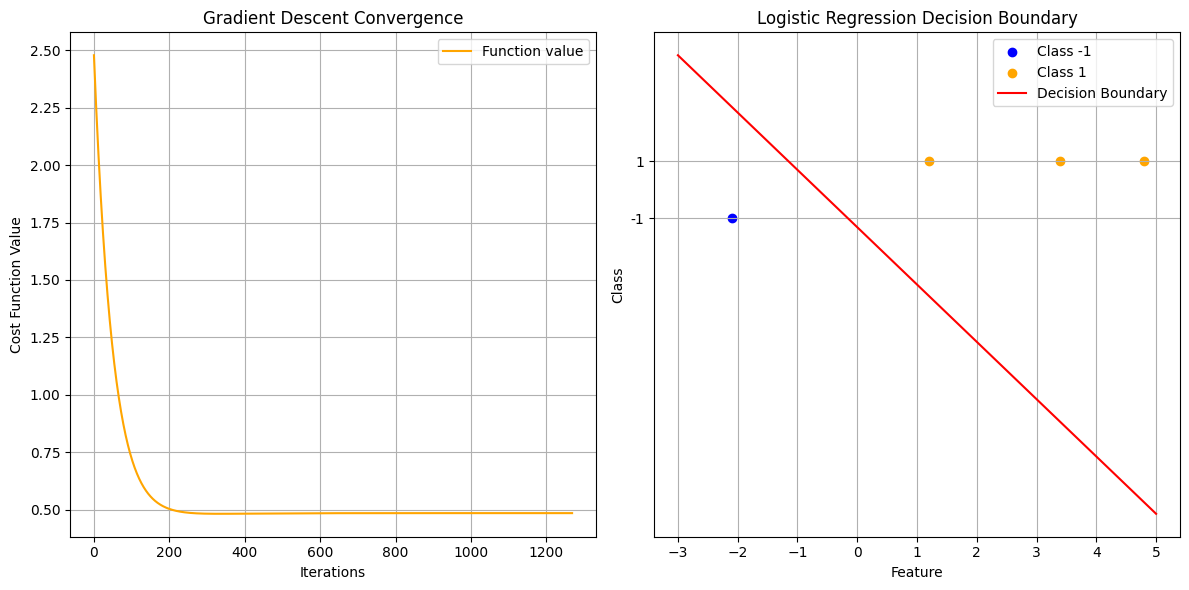

In [24]:
#TASK2.5
# Install necessary packages
!pip install numpy matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Define the BaseSmoothOracle class if not already defined
class BaseSmoothOracle:
    def func(self, x):
        raise NotImplementedError

    def grad(self, x):
        raise NotImplementedError

    def hess(self, x):
        raise NotImplementedError

    def get_opt(self):
        raise NotImplementedError

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        z = self.A.dot(x)
        return np.mean(np.log(1 + np.exp(-self.b * z))) + (self.C / 2) * np.linalg.norm(x)**2

    def grad(self, x):
        z = self.A.dot(x)
        p = 1 / (1 + np.exp(-z))
        return -self.A.T.dot(self.b - p) / len(self.b) + self.C * x

    def hess(self, x):
        z = self.A.dot(x)
        p = 1 / (1 + np.exp(-z))
        diag = p * (1 - p)
        H = self.A.T.dot(np.diag(diag)).dot(self.A) / len(self.b) + self.C * np.eye(len(x))
        return H

    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression,
        here we have to cheat a bit.
        """
        LR = LogisticRegression(fit_intercept=False, C=1./self.C/len(self.b))
        LR.fit(self.A, (self.b + 1) / 2)  # Scale targets to 0 and 1
        return LR.coef_[0]

# Given dataset
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8], [1, 3.4]])
b = np.array([-1, 1, 1, 1])

# Initialize the logistic regression oracle
oracle = LogRegOracle(A, b)

# Function for gradient descent
def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000, trace=False):
    history = {'func': []}
    x_k = np.copy(x_0)

    for i in range(max_iter):
        grad = oracle.grad(x_k)
        x_k -= learning_rate * grad
        history['func'].append(oracle.func(x_k))

        if np.linalg.norm(grad) < tolerance:
            break

    return x_k, "success", history

# Run gradient descent
initial_weights = np.array([1.0, 2.0])  # Starting point
learning_rate = 0.01  # Learning rate
tolerance = 1e-6  # Tolerance

# Execute gradient descent
x_star, msg, history = gradient_descent(oracle, initial_weights, learning_rate, tolerance)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot the convergence behavior
plt.subplot(1, 2, 1)
plt.plot(history['func'], color='orange', label='Function value')
plt.title('Gradient Descent Convergence')
plt.xlabel('Iterations')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid()

# Plot the decision boundary
plt.subplot(1, 2, 2)
xx = np.linspace(-3, 5, 100)
yy = -(oracle.get_opt()[0] + oracle.get_opt()[1] * xx) / oracle.get_opt()[1]  # Decision boundary
plt.scatter(A[:, 1][b == -1], np.zeros_like(A[:, 1][b == -1]), color='blue', label='Class -1')
plt.scatter(A[:, 1][b == 1], np.ones_like(A[:, 1][b == 1]), color='orange', label='Class 1')
plt.plot(xx, yy, color='red', label='Decision Boundary')
plt.title('Logistic Regression Decision Boundary')
plt.xlabel('Feature')
plt.ylabel('Class')
plt.yticks([0, 1], ['-1', '1'])
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
#TASK2.7
# Install necessary packages
!pip install numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Load the breast cancer dataset
breast = load_breast_cancer()
X = breast['data']
y = breast['target']
y[y == 0] = -1  # Change labels to -1 for logistic regression

# Choose a feature (for example, the first feature)
feature_index = 0  # You can choose any feature index
X_feature = X[:, feature_index].reshape(-1, 1)

# Define the Logistic Regression Oracle
class LogRegOracle:
    def __init__(self, X, y, regcoef=1):
        self.X = X
        self.y = y
        self.C = regcoef
        self.m = len(y)

    def func(self, w):
        logits = self.X.dot(w)
        return np.mean(np.log(1 + np.exp(-self.y * logits))) + (self.C / 2) * np.sum(w ** 2)

    def grad(self, w):
        logits = self.X.dot(w)
        predictions = 1 / (1 + np.exp(-logits))
        return (-self.X.T.dot(self.y * (1 - predictions)) / self.m) + self.C * w

    def hess(self, w):
        logits = self.X.dot(w)
        predictions = 1 / (1 + np.exp(-logits))
        diag_hessian = predictions * (1 - predictions)
        return (self.X.T.dot(diag_hessian[:, None] * self.X) / self.m) + self.C * np.eye(len(w))

    def get_opt(self):
        from sklearn.linear_model import LogisticRegression
        LR = LogisticRegression(fit_intercept=False, C=1. / self.C)
        LR.fit(self.X, (self.y + 1) / 2)  # Convert -1 to 0 for sklearn
        return LR.coef_[0]

# Define the gradient descent function (assumed to be defined earlier)
def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000, trace=False):
    history = {'func': []}
    x_k = np.copy(x_0)

    for i in range(max_iter):
        grad = oracle.grad(x_k)
        x_k -= learning_rate * grad
        history['func'].append(oracle.func(x_k))

        if np.linalg.norm(grad) < tolerance:
            break

    return x_k, "success", history

# Initialize the logistic regression oracle
oracle = LogRegOracle(X_feature, y)

# Set learning rate and initial weights
learning_rate = 0.01
initial_weights = np.zeros(X_feature.shape[1])

# Run gradient descent
x_star, msg, history = gradient_descent(oracle, initial_weights, learning_rate, trace=True)

# Visualize the results
plt.figure(figsize=(12, 6))

# Scatter plot of the data
plt.subplot(1, 2, 1)
plt.scatter(X_feature[y == -1], np.zeros_like(X_feature[y == -1]), color='blue', label='Class -1')
plt.scatter(X_feature[y == 1], np.ones_like(X_feature[y == 1]), color='orange', label='Class 1')
plt.title('Breast Cancer Data Points')
plt.xlabel('Feature')
plt.ylabel('Class')
plt.yticks([0, 1], ['-1', '1'])
plt.legend()
plt.grid()

# Plot the convergence behavior
plt.subplot(1, 2, 2)
plt.plot(history['func'], color='orange', label='Function value')
plt.title('Gradient Descent Convergence')
plt.xlabel('Iterations')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
